# Ōura Data + Subjective Data
9 apr 2021
___


Over the course of a year, I collected some subjective measures of wellness in order to do some comparing with the objective data of the oura ring. The thing of most interest is if any relation exists between my sleep scores and readiness scores correpsond roughly with how I felt. I also have a suspicion that I am a relatively fast coffee metaboliser, in which case, I may be unnecessarily taking on opportunity cost by not having afternoon (1pm-3pm) coffees.

I'll expand further later on, but that should be enough to set the motivational scene and suggest some direction regarding the sort of hypotheses I want to tackle with this analysis. Generally, this is more of a sandbox for general exploration and mucking around with the data and checking ideas.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import numpy as np
import seaborn as sns

In [2]:
# --- Data import 

coffee_iphone = pd.read_csv("data/coffee_iphone.csv")
coffee_ipad = pd.read_csv("data/coffee_ipad.csv")
measure_iphone = pd.read_csv("data/measure_iphone.csv")
measure_ipad = pd.read_csv("data/measure_ipad.csv")

# --- date bounds
lower_bound = dt.datetime.strptime("2020-01-01", "%Y-%m-%d")
upper_bound = dt.datetime.strptime("2021-01-28", "%Y-%m-%d")

In [3]:
for i in measure_ipad.date.unique():
    print(i in measure_iphone.date.unique())

False
False
False
False
False
False


In [4]:
# --- Concatenate coffee data

all_coffee = coffee_ipad.append(coffee_iphone)
all_coffee.date = pd.to_datetime(all_coffee.date, format="%d/%m/%Y")
all_coffee = all_coffee[all_coffee.date <= upper_bound]
print(all_coffee.info())

# --- Measure

all_measure = measure_ipad.append(measure_iphone)
all_measure.date = pd.to_datetime(all_measure.date, format="%d/%m/%Y")
all_measure = all_measure[all_measure.date < upper_bound]
print(all_measure.info())
# measure = all_measure.set_index('date')

# --- Make datetime index

base = max(min(all_coffee.date), min(all_measure.date))
max_len = max(max(all_coffee.date) - base, max(all_measure.date) - base).days
all_dates = [base + dt.timedelta(days=i) for i in range(max_len)]

dt_index = pd.DatetimeIndex(all_dates)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    623 non-null    datetime64[ns]
 1   time    623 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 14.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 0 to 372
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          379 non-null    datetime64[ns]
 1   morning_mood  379 non-null    int64         
 2   meditation    379 non-null    int64         
 3   work_quality  379 non-null    int64         
 4   trained       379 non-null    int64         
 5   overall_mood  379 non-null    int64         
 6   alcohol       379 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 23.7 KB
None


In [5]:
print("Date span: ", min(dt_index), max(dt_index))
print("Date length: ", len(dt_index))
print("Coffee len: ", len(all_coffee))
print("Measure len: ", len(all_measure))

Date span:  2020-01-01 00:00:00 2021-01-27 00:00:00
Date length:  393
Coffee len:  623
Measure len:  379


In [6]:
# --- Build coffee df with some columns

coffee = pd.DataFrame(index=dt_index, columns=["times"])
for date in coffee.index:
    times = []
    for i in all_coffee[all_coffee['date'] == date].itertuples(index=False):
        entry_date = i[0]
        entry_time = i[1]
        datestr = str(entry_date).split(' ')[0] + " " + entry_time
        entry = dt.datetime.strptime(datestr, "%Y-%m-%d %H:%M")
        
        times.append(entry)
    coffee.times.loc[date] = times
    
# --- Coffee count
coffee_count = [len(i[1][0]) for i in coffee.iterrows()]
count_series = pd.Series(coffee_count, index = coffee.index)
coffee['coffee_count'] = count_series

# --- Earliest and latest coffee
earliest = [min(i[1][0]) if i[1][0] != [] else None for i in coffee.iterrows()]
latest = [max(i[1][0]) if i[1][0] != [] else None for i in coffee.iterrows()]
coffee['earliest'] = earliest
coffee['earliest'] = [(coffee.loc[x].earliest - x).total_seconds()/60 for x in coffee.index]
coffee['latest'] = latest
coffee['latest'] = [(coffee.loc[x].latest - x).total_seconds()/60 for x in coffee.index]

coffee.head()

,times,coffee_count,earliest,latest
2020-01-01,[],0,NaN,NaN
2020-01-02,"[2020-01-02 07:32:00, 2020-01-02 10:32:00]",2,452.0,632.0
2020-01-03,"[2020-01-03 06:30:00, 2020-01-03 14:06:00, 202...",3,390.0,846.0
2020-01-04,[],0,NaN,NaN
2020-01-05,[2020-01-05 07:50:00],1,470.0,470.0


In [7]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 393 entries, 2020-01-01 to 2021-01-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   times         393 non-null    object 
 1   coffee_count  393 non-null    int64  
 2   earliest      366 non-null    float64
 3   latest        366 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 25.4+ KB


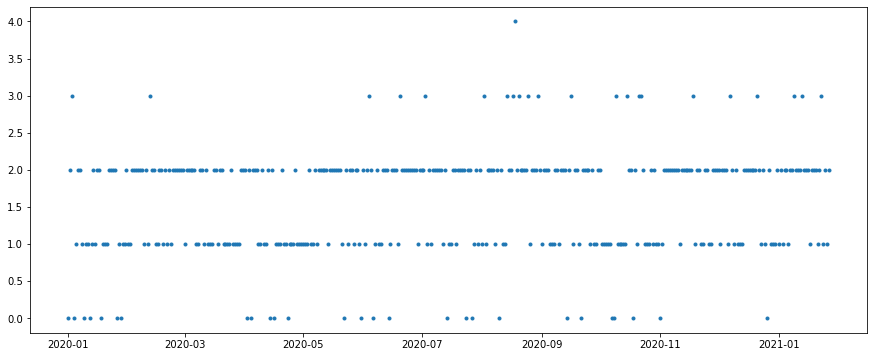

In [8]:
_, ax = plt.subplots(1, figsize=(15, 6))
ax.plot(coffee.index, coffee.coffee_count,'.');

In [9]:
measure = pd.DataFrame(index=dt_index, columns=all_measure.columns)

for d in all_measure.iterrows():
    measure.loc[d[1][0]] = d[1]
    
measure.head()

,date,morning_mood,meditation,work_quality,trained,overall_mood,alcohol
2020-01-01,2020-01-01 00:00:00,8,0,3,1,8,1
2020-01-02,2020-01-02 00:00:00,8,0,5,0,8,1
2020-01-03,2020-01-03 00:00:00,5,0,8,1,8,0
2020-01-04,2020-01-04 00:00:00,5,0,8,0,8,1
2020-01-05,2020-01-05 00:00:00,3,0,5,0,5,0


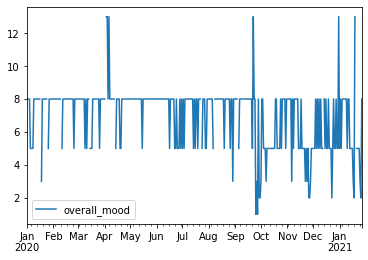

In [10]:
measure.plot(y="overall_mood");

In [11]:
# --- Choose date boundaries and check all dates are present

print("Coffee min, max, len: ", min(coffee.index), max(coffee.index), len(coffee.index))
print("Measure min, max, len: ", min(measure.index), max(measure.index), len(measure.index))

Coffee min, max, len:  2020-01-01 00:00:00 2021-01-27 00:00:00 393
Measure min, max, len:  2020-01-01 00:00:00 2021-01-27 00:00:00 393


Now to import Oura data.

#### Interpolation

Note, use pd.interpolate for missing values and zeros

There's a few different ways of using interpolation. The default mode is the linear method. This just makes a straight line to fill in the gaps. While this is pretty intuitive, I had some concerns regarding autocorrelation being introduced by using this method. Asking a stats person as a sanity check confirms that yes, while it would introduce a small amount of autocorrelation, it wouldnt be to a degree that is anything more than trivial.

In [12]:
oura_import = pd.read_csv("data/oura.csv")

# --- Convert datetimes to UTC

oura_import.date = pd.to_datetime(oura_import.date, format="%Y/%m/%d")

def fix_time(x):
    if type(x) != str:
        return pd.NaT
    return int(dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z").strftime("%s"))

new_bedtime = list(map(fix_time, oura_import['Bedtime Start'].values))
oura_import["Bedtime Start"] = pd.Series(new_bedtime).fillna(0).replace(0, np.nan)
oura_import["Bedtime Start"] = oura_import["Bedtime Start"].interpolate(method="linear", axis=0).astype(int)

new_bedtime_end = list(map(fix_time, oura_import['Bedtime End'].values))
oura_import['Bedtime End'] = pd.Series(new_bedtime_end).fillna(0).replace(0, np.nan)
oura_import['Bedtime End'] = oura_import['Bedtime End'].interpolate(method="linear", axis=0).astype(int)

display(oura_import.head())
print("Date range: ", min(oura_import.date), max(oura_import.date))

,date,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,Total Bedtime,...,long_periods_of_inactivity,readiness_score,previous_night_score,sleep_balance_score,previous_day_activity_score,activity_balance_score,temperature_score,resting_heart_rate_score,hrv_balance_score,recovery index_score
0,2019-12-30,72.0,60.0,37.0,96.0,88.0,61.0,97.0,100.0,25740.0,...,1,68.0,53.0,68.0,99.0,97.0,100.0,78.0,NaN,12.0
1,2019-12-31,72.0,62.0,55.0,96.0,83.0,50.0,89.0,100.0,27000.0,...,1,77.0,53.0,65.0,66.0,94.0,81.0,100.0,NaN,100.0
2,2020-01-01,75.0,71.0,61.0,95.0,74.0,52.0,91.0,100.0,31380.0,...,0,75.0,60.0,66.0,81.0,89.0,100.0,95.0,NaN,69.0
3,2020-01-02,75.0,71.0,52.0,95.0,72.0,56.0,97.0,100.0,31680.0,...,0,73.0,60.0,66.0,100.0,88.0,100.0,53.0,NaN,100.0
4,2020-01-03,67.0,62.0,9.0,93.0,72.0,54.0,94.0,100.0,28980.0,...,0,72.0,40.0,64.0,98.0,88.0,95.0,100.0,NaN,58.0


Date range:  2019-12-30 00:00:00 2021-02-11 00:00:00


In [13]:
oura_import['Bedtime End']

0      1577643090
1      1577731623
2      1577821418
3      1577908202
4      1577991083
          ...    
404    1612653872
405    1612733071
406    1612817671
407    1612902272
408    1612986513
Name: Bedtime End, Length: 409, dtype: int64

Converting bedtime start and end back to sydney time will require:

```py
dt.datetime.fromtimestamp(int(test_utc.strftime("%s"))).astimezone(correct_tzinfo)
```

correct tzinfo is utc+11:00 for sydney

In [14]:
x = lambda x: "_".join((x.lower().split(" ")))
oura_import.columns = map(x, oura_import.columns.values)
oura_import.head()
# oura_import.columns.values

,date,sleep_score,total_sleep_score,rem_sleep_score,deep_sleep_score,sleep_efficiency_score,restfulness_score,sleep_latency_score,sleep_timing_score,total_bedtime,...,long_periods_of_inactivity,readiness_score,previous_night_score,sleep_balance_score,previous_day_activity_score,activity_balance_score,temperature_score,resting_heart_rate_score,hrv_balance_score,recovery_index_score
0,2019-12-30,72.0,60.0,37.0,96.0,88.0,61.0,97.0,100.0,25740.0,...,1,68.0,53.0,68.0,99.0,97.0,100.0,78.0,NaN,12.0
1,2019-12-31,72.0,62.0,55.0,96.0,83.0,50.0,89.0,100.0,27000.0,...,1,77.0,53.0,65.0,66.0,94.0,81.0,100.0,NaN,100.0
2,2020-01-01,75.0,71.0,61.0,95.0,74.0,52.0,91.0,100.0,31380.0,...,0,75.0,60.0,66.0,81.0,89.0,100.0,95.0,NaN,69.0
3,2020-01-02,75.0,71.0,52.0,95.0,72.0,56.0,97.0,100.0,31680.0,...,0,73.0,60.0,66.0,100.0,88.0,100.0,53.0,NaN,100.0
4,2020-01-03,67.0,62.0,9.0,93.0,72.0,54.0,94.0,100.0,28980.0,...,0,72.0,40.0,64.0,98.0,88.0,95.0,100.0,NaN,58.0


In [15]:
oura = oura_import[oura_import.date < upper_bound]
oura = oura[oura.date >= lower_bound]
display(oura.head())
print("Date range: ", min(oura.date), max(oura.date))

,date,sleep_score,total_sleep_score,rem_sleep_score,deep_sleep_score,sleep_efficiency_score,restfulness_score,sleep_latency_score,sleep_timing_score,total_bedtime,...,long_periods_of_inactivity,readiness_score,previous_night_score,sleep_balance_score,previous_day_activity_score,activity_balance_score,temperature_score,resting_heart_rate_score,hrv_balance_score,recovery_index_score
2,2020-01-01,75.0,71.0,61.0,95.0,74.0,52.0,91.0,100.0,31380.0,...,0,75.0,60.0,66.0,81.0,89.0,100.0,95.0,NaN,69.0
3,2020-01-02,75.0,71.0,52.0,95.0,72.0,56.0,97.0,100.0,31680.0,...,0,73.0,60.0,66.0,100.0,88.0,100.0,53.0,NaN,100.0
4,2020-01-03,67.0,62.0,9.0,93.0,72.0,54.0,94.0,100.0,28980.0,...,0,72.0,40.0,64.0,98.0,88.0,95.0,100.0,NaN,58.0
5,2020-01-04,71.0,63.0,62.0,66.0,79.0,53.0,99.0,100.0,28140.0,...,0,74.0,50.0,61.0,97.0,92.0,92.0,79.0,NaN,95.0
6,2020-01-05,64.0,64.0,27.0,99.0,65.0,62.0,64.0,67.0,30300.0,...,0,60.0,33.0,60.0,91.0,86.0,53.0,54.0,NaN,91.0


Date range:  2020-01-01 00:00:00 2021-01-27 00:00:00


In [16]:
print("Len oura, Len measure, Len coffee", len(oura), len(measure), len(coffee))
for i in coffee.index.values:
    if i not in oura.date.values:
        print(i)

Len oura, Len measure, Len coffee 392 393 393
2020-12-31T00:00:00.000000000


In [17]:
oura.iloc[364:366]

,date,sleep_score,total_sleep_score,rem_sleep_score,deep_sleep_score,sleep_efficiency_score,restfulness_score,sleep_latency_score,sleep_timing_score,total_bedtime,...,long_periods_of_inactivity,readiness_score,previous_night_score,sleep_balance_score,previous_day_activity_score,activity_balance_score,temperature_score,resting_heart_rate_score,hrv_balance_score,recovery_index_score
366,2020-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


why

In [18]:
oura = oura.drop('sleep_timing.1', axis=1)
oura = oura.rename(columns={"temperature_deviation_(°c)": "temperature_deviation_celcius"})
oura.columns

Index(['date', 'sleep_score', 'total_sleep_score', 'rem_sleep_score',
       'deep_sleep_score', 'sleep_efficiency_score', 'restfulness_score',
       'sleep_latency_score', 'sleep_timing_score', 'total_bedtime',
       'total_sleep_time', 'awake_time', 'rem_sleep_time', 'light_sleep_time',
       'deep_sleep_time', 'restless_sleep', 'sleep_efficiency',
       'sleep_latency', 'sleep_timing', 'bedtime_start', 'bedtime_end',
       'average_resting_heart_rate', 'lowest_resting_heart_rate',
       'average_hrv', 'temperature_deviation_celcius', 'respiratory_rate',
       'activity_score', 'stay_active_score', 'move_every_hour_score',
       'meet_daily_targets_score', 'training_frequency_score',
       'training_volume_score', 'recovery_time_score', 'activity_burn',
       'total_burn', 'target_calories', 'steps', 'daily_movement',
       'inactive_time', 'rest_time', 'low_activity_time',
       'medium_activity_time', 'high_activity_time', 'non_wear_time',
       'average_met', 'long_pe

In [19]:
missing_date = oura.loc[366].date + dt.timedelta(days=1)
new = oura.loc[366].copy()
new.date = new.date + dt.timedelta(days=1)
oura.loc["missing"] = new

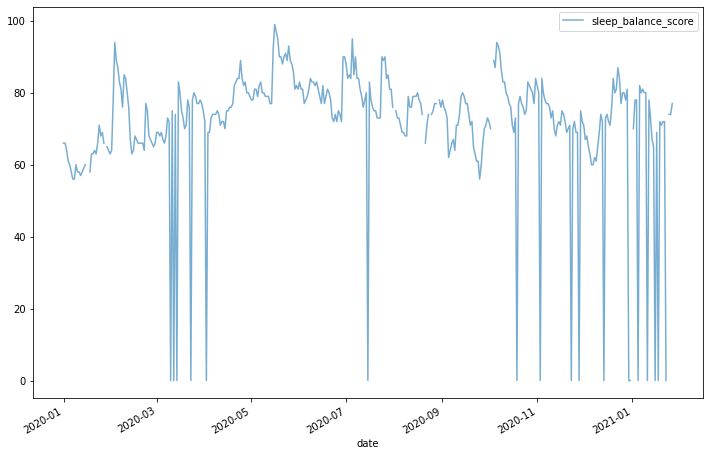

In [20]:
_, ax = plt.subplots(1, figsize=(12, 8))
y = "sleep_balance_score"
oura.plot(x='date', y=y, ax=ax, alpha=0.6);

There are nans and 0's to deal with. 

Scores tend to have 0's, non scores tend to have nans. I'm going to use `pd.interpolate` to fill those

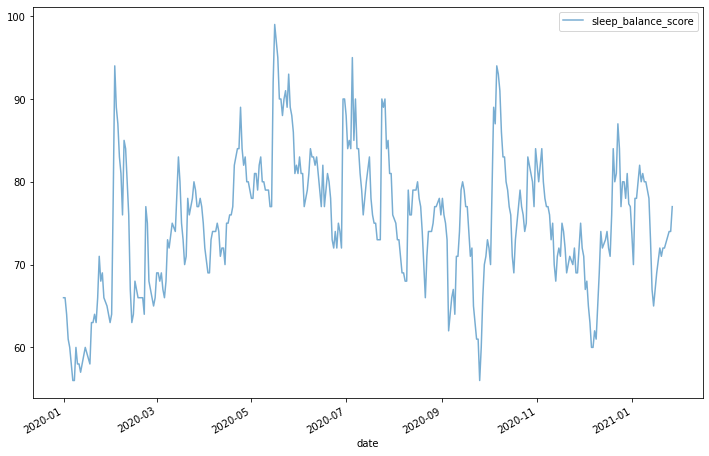

In [21]:
# oura = oura.fillna(0)
check = oura.copy()
check = check.replace(0, np.nan)

check.interpolate(method="linear", axis=0, inplace=True)

_, ax = plt.subplots(1, figsize=(12, 8))
y = "sleep_balance_score"
check.plot(x='date', y=y, ax=ax, alpha=0.6);

In [22]:
oura = oura.interpolate(method="linear", axis=0)

# --- Remove Zeros from score columns separately

score_cols = [i for i in oura.columns if "score" in i][15:]
oura[score_cols] = oura[score_cols].replace(0, np.nan)
oura[score_cols] = oura[score_cols].interpolate(method="linear", axis=0)

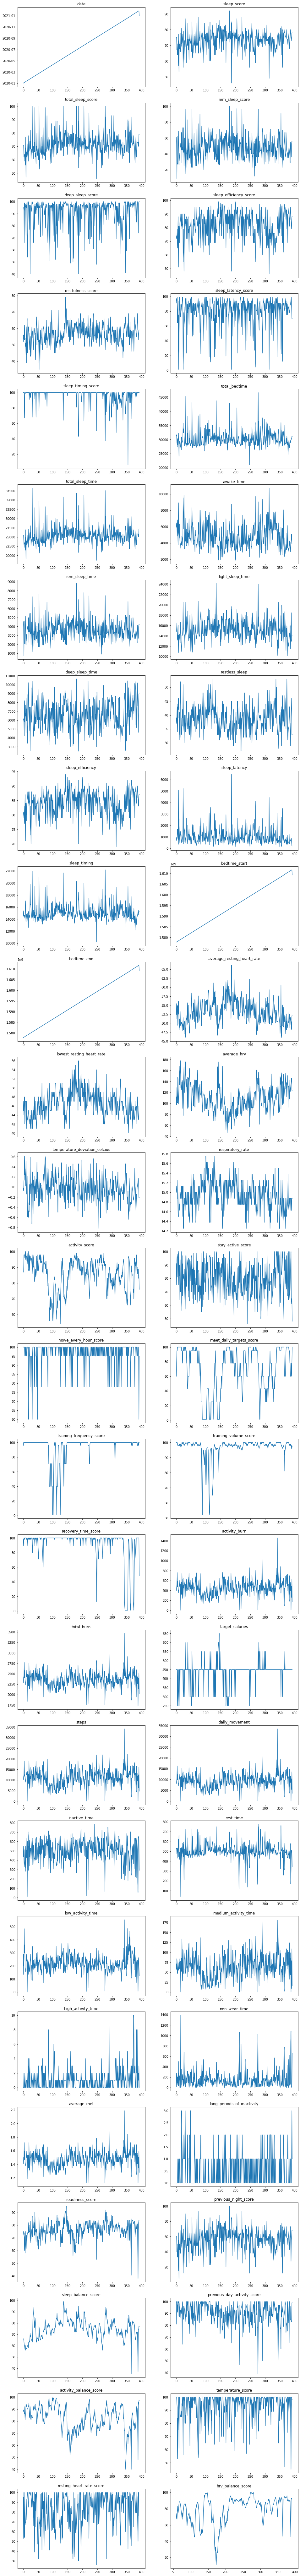

In [23]:
x = len(oura.index)
_, axes = plt.subplots(len(oura.columns)//2, 2, figsize=(16,150))
axes = axes.flatten()
for i, ax in enumerate(axes):
    try:
        ax.plot(range(x), oura[oura.columns[i]])
        ax.set_title(oura.columns[i])
    except:
        print(oura.columns[i])

In [24]:
oura.to_csv("data/oura_clean.csv", sep=',')

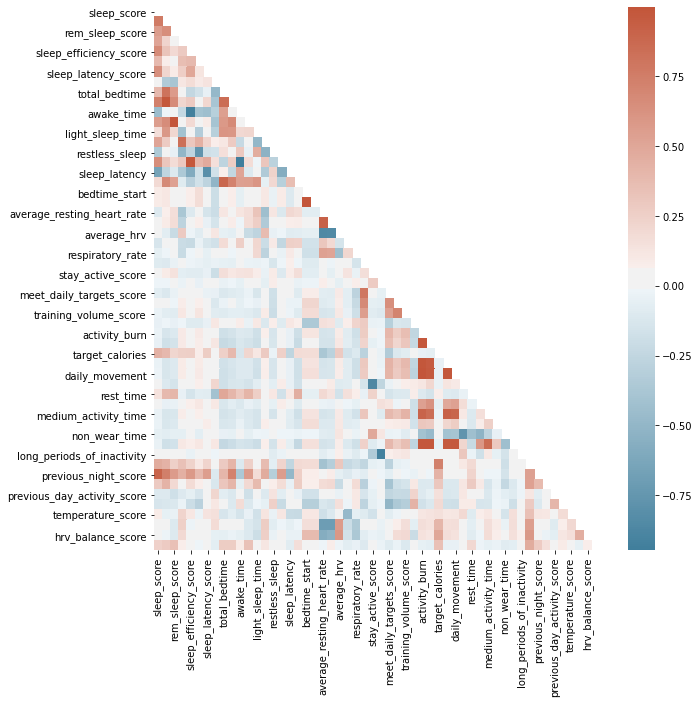

In [25]:
# --- Correlation

_, ax = plt.subplots(1, figsize=(10, 10))
corr = oura.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap);

In [135]:
# --- Mood correlations with Oura 

var = measure.columns[1:] # remove datetime column
mood = measure[var].astype(float)

check = oura.copy()
check[var] = mood.values

corr = check.corr()
measure_corr = corr[var]

neg_corrs = measure_corr.mask(measure_corr > -0.3 , np.nan).dropna(axis=0, how='all')
pos_corrs = measure_corr.mask(measure_corr < 0.3 , np.nan).dropna(axis=0, how='all')
display(pos_corrs)
display(neg_corrs)

,morning_mood,meditation,work_quality,trained,overall_mood,alcohol
sleep_score,0.385057,NaN,NaN,NaN,NaN,NaN
total_sleep_score,0.320431,NaN,NaN,NaN,NaN,NaN
previous_night_score,0.396857,NaN,NaN,NaN,NaN,NaN
morning_mood,1.000000,NaN,NaN,NaN,0.300669,NaN
meditation,NaN,1.0,NaN,NaN,NaN,NaN
work_quality,NaN,NaN,1.0,NaN,NaN,NaN
trained,NaN,NaN,NaN,1.0,NaN,NaN
overall_mood,0.300669,NaN,NaN,NaN,1.000000,NaN
alcohol,NaN,NaN,NaN,NaN,NaN,1.0


,morning_mood,meditation,work_quality,trained,overall_mood,alcohol
bedtime_start,NaN,NaN,NaN,NaN,-0.360025,NaN
bedtime_end,NaN,NaN,NaN,NaN,-0.360035,NaN


## Correlations of interest

All are on a datapoints are daily resolution
- Respiratory rate x :
    - deep sleep (moderate negative)
    - light sleep (weak positive)
    - Average HRV (moderate negative)
    - temperature deviation (weak positive)
    - activity score $t-1$ (weak negative)
- rem sleep x 
    - bed time (moderate positive)
    - midpoint (moderate positive)
    - time in bed (moderate positive)
    - time in bed $t-1$ (slight negative)
    - total sleep time (moderate positive)
    - total sleep time $t-1$ (slight negative)
    - wake up time (moderate positive)
    - wake up time $t-1$ (slight negatvie)
    - average HRV (moderate negative)
    - readiness score (moderate positive)
    - readiness score $t-1$ (moderate negative)
- deep sleep x
    - bed time 

length of cols:  54 
length of oura cols:  55


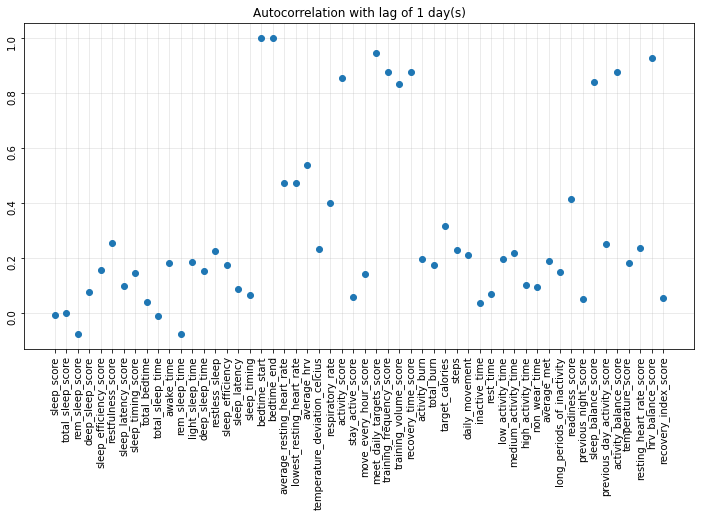

In [26]:
# --- Autocorrelation across Oura data

lag = 1

cols = [col for col in oura.columns if oura[col].dtype =="float" or oura[col].dtype =="int"]
length = range(len(cols))
autocorrs = np.array([oura[col].autocorr(lag=lag) for col in cols])

print("length of cols: ", len(length), "\nlength of oura cols: ", len(oura.columns))

_, ax = plt.subplots(1, figsize=(12, 6))
ax.tick_params(labelrotation=90);
ax.grid(axis="both", alpha=0.3);
ax.set(title="Autocorrelation with lag of {} day(s)".format(lag))
ax.plot(cols, autocorrs, 'o');

## Autocorrelation - Timeseries Crashcourse
[With seasonal stuff](https://python-bloggers.com/2021/04/arima-model-in-python/)
- Check for stationarity (constant mean and var across the dataset)
- Use $\Delta$ of orders until the above happens
- Get ACF (autocorr func) and PACF (partial ...) plots using statsmodels.graphics
- 


Vars of interest 
- hrv_balance_score
- average hrv
- sleep_balance_score
- temperature_deviation_celcius

In [27]:
oura.columns

Index(['date', 'sleep_score', 'total_sleep_score', 'rem_sleep_score',
       'deep_sleep_score', 'sleep_efficiency_score', 'restfulness_score',
       'sleep_latency_score', 'sleep_timing_score', 'total_bedtime',
       'total_sleep_time', 'awake_time', 'rem_sleep_time', 'light_sleep_time',
       'deep_sleep_time', 'restless_sleep', 'sleep_efficiency',
       'sleep_latency', 'sleep_timing', 'bedtime_start', 'bedtime_end',
       'average_resting_heart_rate', 'lowest_resting_heart_rate',
       'average_hrv', 'temperature_deviation_celcius', 'respiratory_rate',
       'activity_score', 'stay_active_score', 'move_every_hour_score',
       'meet_daily_targets_score', 'training_frequency_score',
       'training_volume_score', 'recovery_time_score', 'activity_burn',
       'total_burn', 'target_calories', 'steps', 'daily_movement',
       'inactive_time', 'rest_time', 'low_activity_time',
       'medium_activity_time', 'high_activity_time', 'non_wear_time',
       'average_met', 'long_pe

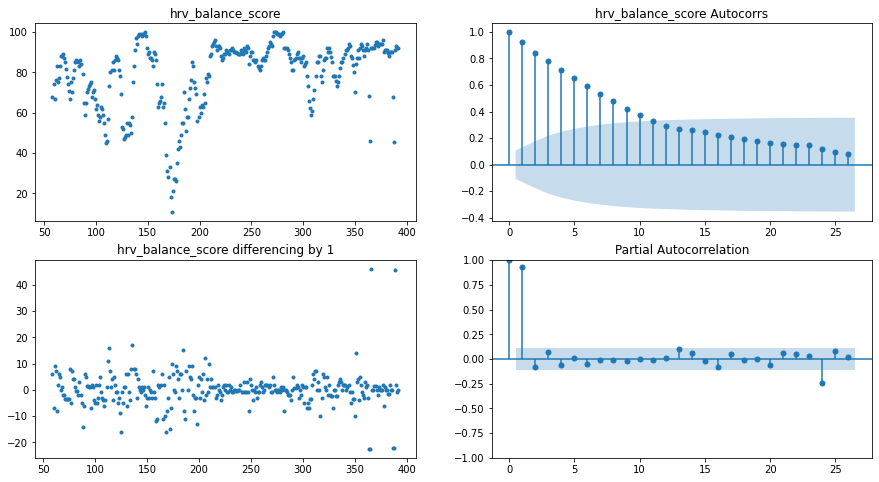

In [38]:
# --- Autocorrelation Analysis

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for i in oura.columns:
check_var = "hrv_balance_score"
scores = oura[check_var]
n_days = len(scores)
n_autocorr = 28
delta = 1
differencing = pd.Series(scores[delta:].values - scores[:-delta].values)

_, ax = plt.subplots(2,2, figsize=(15, 8))
ax = ax.flatten()
start, nth_day = 0,1

ax[0].plot(range(n_days)[start::nth_day], scores[start::nth_day], '.');
ax[0].set_title(check_var);


fig1=plot_acf(scores.dropna(), ax=ax[1]) 
ax[1].set_title("{} Autocorrs".format(check_var));

ax[2].plot(range(n_days)[delta:], differencing, '.');
ax[2].set_title("{} differencing by 1".format(check_var));

fig2=plot_pacf(scores.dropna(), ax=ax[3]) 

# ax[3].bar(range(len_fortnight)[1:], diff_autocorrs[1:])
ax[3].set_ylim(-1, 1);

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4)'>

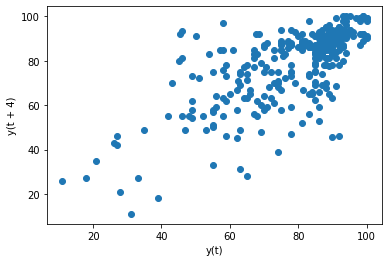

In [34]:
lag_len = 5
lags = range(lag_len)
cols = 2
# _, axes = plt.subplots(lag_len//cols, cols, figsize=(12, 30))
# axes = axes.flatten()

pd.plotting.lag_plot(scores, lag=4)#, ax=ax)
    
# for i, ax in enumerate(axes):
#     pd.plotting.lag_plot(oura[check_var], lag=i, ax=ax)
#     ax.set_title("check_var plot with lag {}".format(i))

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(scores, order=(1,1,1),seasonal_order=(0, 0, 0, 0))
result=model.fit()

In [ ]:
result.resid.plot(kind='kde')

In [ ]:
scores.index

In [ ]:
from pandas.tseries.offsets import DateOffset
# new_dates=[scores.index[-1]+DateOffset(months=x) for x in range(1,48)]
new_index = range(n_days, n_days+48)

df_pred=pd.DataFrame(index=new_index, columns=[check_var])
df_pred.head()

df2=pd.concat([scores,df_pred])

df2['predictions']=result.predict(start=n_days-1,end=n_days-1+48)
df2[[check_var,'predictions']].plot()

In [ ]:
measure = measure[measure.columns[1:]].astype(float)

In [ ]:
cols = [col for col in measure.columns if measure[col].dtype == "float" or measure[col].dtype == "int"]
print("length of cols: ", len(cols), "\nlength of oura cols: ", len(measure.columns))
lag = 2

autocorrs = np.array([measure[col].autocorr(lag=lag) for col in cols])

_, ax = plt.subplots(1, figsize=(12, 6))
# ax.set_xticklabels(labels, rotation=45)
ax.tick_params(labelrotation=90);
ax.grid(axis="both", alpha=0.3);
ax.set(title="Autocorrelation with lag of {} days".format(lag))
ax.plot(cols, autocorrs, 'o');

I was just listening to Hubermann's podcast and learned something worth taking a look at. I'm not going to word it quite right but either increased HRV increases the potential impact of antidepressants or a low HRV prevents antidepressants from working. I don't take antidepressants, but he mentioned it in a broader discussion about seratonergic and dopaminergic mechanisms and all, so whatever it is, I might see some kind of positive correlation between HRV and subjective mood. 